### Loading Required Libraries

In [3]:
# import the necessary libraries

from modules import PreProcessing, functions
from sqlite3 import connect 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from itertools import chain
from collections import Counter
import nltk
import warnings
warnings.filterwarnings("ignore")

# to ensure all changes are reflected 
# in-case jupyter notebook was already oppened

from importlib import reload
reload(PreProcessing)
reload(functions)

project_dir = '/Users/nima/repository/Project_509'
#project_dir = '/Users/oscargil/Library/CloudStorage/GoogleDrive-gil.oscar@gmail.com/My Drive/Masters of Science in Applied Data Science (University of San Diego)/2022 - S6 - Fall Courses/Applied Text Mining - ADS 509/TeamProject'

In [2]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import TensorBoard

### Section 1 - Create a Suport vector machine 

In [4]:
databse_file = 'database.db'
main = connect(databse_file)

sql_statement_laod_data = '''
SELECT 
    reviews.id, 
    reviews.course_name, 
    review_text_clean.clean_sentence 

FROM review_text_clean
JOIN reviews ON 
    review_text_clean.review_id = reviews.id
'''

df = pd.read_sql_query(sql_statement_laod_data, main)

# create a new column that holds tokens of clean_sentence
df['tokens'] = df['clean_sentence'].apply(lambda x: x.split(' '))
df.sample(5)

,id,course_name,clean_sentence,tokens
43667,43667,python,thi one best program class ive ever taken easi...,"[thi, one, best, program, class, ive, ever, ta..."
3038,3038,ai-for-everyone,thi best cours beginn aigiv confid know ai,"[thi, best, cours, beginn, aigiv, confid, know..."
41632,41632,python,class professor charl sever interest fun learn...,"[class, professor, charl, sever, interest, fun..."
439,439,ai-for-everyone,veri enlighten peopl zero small amount knowled...,"[veri, enlighten, peopl, zero, small, amount, ..."
20892,20892,foundations-data,like toni explain concept thi cours self refle...,"[like, toni, explain, concept, thi, cours, sel..."


In [5]:
# It is observed that there are tokens with only one character
# its best to remove them as well as they are just adding noise and complexity of the model

def remove_single_character_tokens(row, min_length=3):
    return [word for word in row['tokens'] if len(word) >= min_length]

df['tokens_keep'] = df.apply(remove_single_character_tokens, axis=1)

df['tokens_keep'].sample(5)

32855    [well, explain, cours, offer, veri, good, intr...
58922    [find, thi, incred, cours, subject, discuss, f...
58457    [sometim, cant, recogn, opportun, hand, even, ...
19491                                          [veri, use]
40842    [thi, cours, ive, miss, past, year, tri, learn...
Name: tokens_keep, dtype: object

In [6]:
def exclude_words_that_are_rarely_used(counter_all, min_count=5):
    # remove words that appear less than min_count
    # this will be used to remove the words that are not frequently used
    # since the model can't learn from them effectively

    word_count_before = len(counter_all)
    counter_after = {token:count for token, count in counter_all.items() if count > min_count}
    word_count_after = len(counter_after)
    percentage_dropped = (word_count_before - word_count_after) / word_count_before * 100
    words_dropped = word_count_before - word_count_after

    print('%s rare words (%s) could be dropped to improve the model.' 
          % (f'{words_dropped:,}',f'{percentage_dropped:.1f}%'))
    
    print('unique words before: %s\nunique words after: %s' 
          % (f'{word_count_before:,}', f'{word_count_after:,}'))
    
    return counter_after
    
# using itertool count each elements in tokens column
counter_all = Counter(chain.from_iterable(df['tokens']))
counter_reduced = exclude_words_that_are_rarely_used(counter_all, min_count=5)
words_to_keep = counter_reduced.keys()

20,751 rare words (82.4%) could be dropped to improve the model.
unique words before: 25,194
unique words after: 4,443


In [7]:
# remove the elements in tokens that are not in words_to_keep
def return_words_to_use(row, words_to_keep):
    return [word for word in row['tokens'] if word in words_to_keep]

df['tokens_keep'] = df.apply(lambda row: return_words_to_use(row, words_to_keep), axis=1)


# difference in number of tokens before and after removing the words that are not used often
def get_number_of_words_dropped(row):
    return len(row['tokens']) - len(row['tokens_keep'])

df['number_of_words_dropped'] = df.apply(get_number_of_words_dropped, axis=1)

# sort the dataframe by number_of_words_dropped
df.sort_values(by='number_of_words_dropped', ascending=False, inplace=True)

df.head()

,id,course_name,clean_sentence,tokens,tokens_keep,number_of_words_dropped
9725,9725,excel-essentials,ù ø§ ø´ø§ø¡ ø§ùùù ùø§ ùùø© ø¥ùø§ ø¨ø§ù...,"[ù, ø§, ø´ø§ø¡, ø§ùùù, ùø§, ùùø©, ø¥ùø§...","[ù, ø§, ù, ù, ø¬ø¯ø§, ù, ù, ùù, ù, ø§, ø¬ø¯ø...",106
50478,50478,learning-how-to-learn,trã¨ intã©ress je le recommand pour le amoureu...,"[trã¨, intã©ress, je, le, recommand, pour, le,...","[trã¨, intã©ress, je, le, recommand, pour, le,...",79
50350,50350,learning-how-to-learn,ðñðµðºñð°ñð½ñð¹ ðºñññ ðð¾ð¹ ñð¸ð´ð±ñ...,"[ðñðµðºñð°ñð½ñð¹, ðºñññ, ðð¾ð¹, ñð¸ð...","[ðºñññ, ð½ðµ, ñð¾ð»ñðºð¾, ðºñññ, ð½ð¾,...",76
41757,41757,python,review korean korean mooc learner ì  ì´ ê°ì...,"[review, korean, korean, mooc, learner, ì, , ...","[review, mooc, learner, ì, ì, ì, ì, ì¸, ì, ì...",74
50939,50939,learning-how-to-learn,bu kur hakkä±nda bulunan yorumlardan birã§oäu...,"[bu, kur, hakkä±nda, bulunan, yorumlardan, bir...","[kur, iã§in, 2, kur, iã§in, de, coursera, ya, ...",68


In [8]:
# set seed for reproducibility
np.random.seed(12)

# get index of 20% of random data in the datafram for testing
test_index = np.random.choice(df.index, size=int(len(df)*0.2), replace=False)

# set up the train and test
train = df[~df.index.isin(test_index)]
test = df[df.index.isin(test_index)]

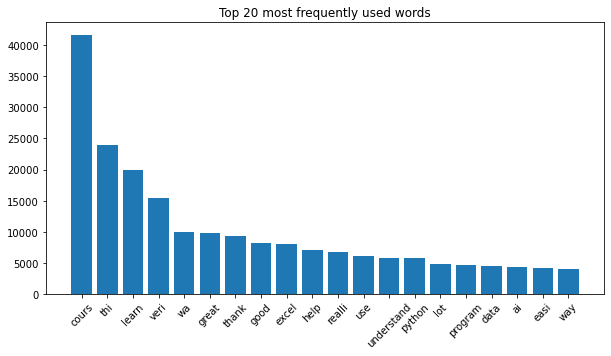

In [9]:
words_to_train_with = Counter(chain.from_iterable(train['tokens_keep']))

# plot the top 20 most frequently used in words_to_train_with
plt.figure(figsize=(10,5))
plt.title('Top 20 most frequently used words')
plt.bar(*zip(*words_to_train_with.most_common(20)))
plt.xticks(rotation=45)
plt.show()

In [10]:
# make a tuple of tokens_keep and classification

def prepare_train_data(row):
    x = {token:True for token in row['tokens_keep']}
    y = row['course_name']
    return (x, y)

train_data = train.apply(prepare_train_data, axis=1)
train_data[0]

({'got': True,
  'comprehens': True,
  'overview': True,
  'ai': True,
  'mean': True,
  'variou': True,
  'concept': True,
  'talk': True,
  'thi': True,
  'context': True,
  'excel': True,
  'cours': True,
  'one': True,
  'start': True,
  'solid': True,
  'ground': True,
  'five': True,
  'star': True,
  'thank': True,
  'andrew': True},
 'ai-for-everyone')

In [11]:
model_nb = nltk.NaiveBayesClassifier.train(train_data)

In [12]:
model_nb.show_most_informative_features(25)

Most Informative Features
                  python = True           python : excel- =   2439.6 : 1.0
                      ai = True           ai-for : excel- =   2143.0 : 1.0
                      dr = True           python : founda =    838.4 : 1.0
              cybersecur = True           introd : learni =    609.3 : 1.0
                 barbara = True           learni : ai-for =    537.1 : 1.0
                   cyber = True           introd : python =    522.1 : 1.0
                   secur = True           introd : excel- =    463.6 : 1.0
                   chuck = True           python : learni =    410.7 : 1.0
                 analyst = True           founda : learni =    406.6 : 1.0
                   audio = True           introd : ai-for =    396.1 : 1.0
                     web = True           python : founda =    368.2 : 1.0
                     ibm = True           introd : ai-for =    316.5 : 1.0
                  analyt = True           founda : learni =    279.7 : 1.0

In [13]:
# make a def to predict the course name using the model_nb
def predict_course_name(row, model, words_to_train_with):
    x = {token:True for token in row['tokens_keep'] if token in words_to_train_with}
        
    return model.classify(x)

test['predicted_course_name'] = test.apply(lambda row: predict_course_name(row, model_nb, words_to_train_with), axis=1)
test[['course_name', 'predicted_course_name']].sample(10)

,course_name,predicted_course_name
27801,foundations-data,excel-essentials
42576,python,python
31688,introduction-cybersecurity-cyber-attacks,introduction-cybersecurity-cyber-attacks
40392,python,python
7943,ai-for-everyone,python
36050,python-network-data,excel-essentials
22343,foundations-data,python
30391,introduction-cybersecurity-cyber-attacks,learning-how-to-learn
50275,learning-how-to-learn,learning-how-to-learn
57037,learning-how-to-learn,learning-how-to-learn


In [14]:
# calculate the accuracy of the model
accuracy = nltk.classify.accuracy(model_nb, train_data)
print('Accuracy of the model: %s' % f'{accuracy:.2%}')

Accuracy of the model: 49.71%


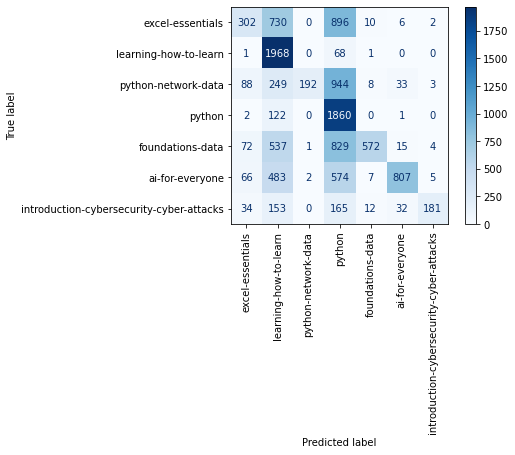

In [15]:
# calculate the confusion matrix of the model using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classification_labels = test['course_name'].unique()
cmx = confusion_matrix(test['course_name'], test['predicted_course_name'], labels=classification_labels)

ConfusionMatrixDisplay(confusion_matrix=cmx, display_labels=list(classification_labels)).plot( cmap='Blues',xticks_rotation='vertical')
plt.show()

In [16]:
# make a dataframe that holds the confusion matrix
cmx_df = pd.DataFrame(cmx, index=classification_labels, columns=classification_labels)
cmx_df

,excel-essentials,learning-how-to-learn,python-network-data,python,foundations-data,ai-for-everyone,introduction-cybersecurity-cyber-attacks
excel-essentials,302,730,0,896,10,6,2
learning-how-to-learn,1,1968,0,68,1,0,0
python-network-data,88,249,192,944,8,33,3
python,2,122,0,1860,0,1,0
foundations-data,72,537,1,829,572,15,4
ai-for-everyone,66,483,2,574,7,807,5
introduction-cybersecurity-cyber-attacks,34,153,0,165,12,32,181


In [17]:
# calculate the precision, recall, f1-measure of the model
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(test['course_name'], test['predicted_course_name'], labels=classification_labels)

# average the precision, recall, f1-measure
precision_avg = np.average(precision)
recall_avg = np.average(recall)
f1_avg = np.average(f1)

# show the results
print('precision: %s \nrecall: %s \nf1-measure: %s' % (f'{precision_avg:.2%}', f'{recall_avg:.2%}', f'{f1_avg:.2%}'))

precision: 72.86% 
recall: 45.64% 
f1-measure: 43.87%


## SVM Model

In [99]:
# using instructions as found in this Medium article:
# https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

from sklearn import model_selection
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['tokens_keep'], df['course_name'],test_size=0.3)


In [62]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(train[['course_name']])
Test_Y = Encoder.fit_transform(test[['course_name']])

In [63]:
Tfidf_vect = TfidfVectorizer(max_features=5000)

In [78]:
Tfidf_vect.fit(str(df[['tokens_keep']]).lower().split())

TfidfVectorizer(max_features=5000)

In [107]:
Train_X_Tfidf = Tfidf_vect.transform(str(Train_X).lower().split())
Test_X_Tfidf = Tfidf_vect.transform(str(Test_X).lower().split())

In [108]:
print(Tfidf_vect.vocabulary_)

{'tokens_keep': 50, '9725': 10, '50478': 7, 'trã': 51, 'intã': 27, 'ress': 42, 'je': 29, 'le': 31, 'recommand': 40, 'pour': 37, '50350': 6, 'ðºñ': 59, 'ð½ðµ': 60, 'ð¾ð': 62, 'ðºð¾': 58, 'ð½ð¾': 61, '41757': 5, 'review': 43, 'mooc': 35, 'learner': 33, '50939': 8, 'kur': 30, 'iã': 28, 'in': 25, 'de': 18, 'coursera': 15, 'ya': 56, '22217': 0, 'video': 53, 'clear': 13, 'direct': 20, 'busi': 12, 'schedul': 45, 'realli': 39, '22218': 1, 'veri': 52, 'good': 22, 'gentl': 21, 'introduct': 26, 'data': 17, 'analysi': 11, '22219': 2, 'help': 24, 'learn': 32, 'point': 36, 'repeat': 41, 'stick': 47, 'less': 34, '22220': 3, 'detail': 19, 'yet': 57, 'straight': 48, 're': 38, '30093': 4, 'wa': 54, 'great': 23, 'cyber': 16, 'secur': 46, 'world': 55, 'th': 49, '60186': 9, 'rows': 44, 'columns': 14}


In [109]:
print(Train_X_Tfidf)

  (8, 51)	1.0
  (27, 24)	1.0
  (49, 39)	1.0
  (50, 23)	1.0
  (51, 54)	1.0
  (52, 52)	1.0
  (53, 22)	1.0
  (56, 53)	1.0
  (67, 50)	1.0


In [110]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

In [114]:
Train_X_Tfidf.shape

(72, 63)

In [115]:
Train_Y.shape

(42130,)

In [126]:
# used a sample of Train_Y shape to prevent the error:
# "ValueError: Found input variables with inconsistent numbers of samples: [72, 42130]"
SVM.fit(Train_X_Tfidf,Train_Y.sample(72))

SVC(gamma='auto', kernel='linear')

In [118]:
predictions_SVM = SVM.predict(Test_X_Tfidf)

In [120]:
predictions_SVM.shape

(80,)

In [122]:
Test_Y.shape

(18056,)

In [148]:
# used a sample of Train_Y shape to prevent the error:
# "ValueError: Found input variables with inconsistent numbers of samples: [80, 18056]"
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y.sample(80))*100)

SVM Accuracy Score ->  26.25
